# Motivation #

- this notebook is also available as a [colab notebook](https://colab.research.google.com/drive/1kErNKAbJlJUpq2jsb0roMJA7kTNB9vY0?usp=sharing)

We will continue to use Vandermonde interpolation as our example for solving least squares problems because the goal of vandermonde interpolation is finding the least squares solution of our interpolated function with the observed data.

While the direct inversion methods used previously worked well for the Vandermonde case, some matrices, especially in CT reconstruction or larger problems are not easily inverted due to their size or large condition number.

For these problems iterative algorithms are used. In this tutorial we walk through the Vandermonde beam hardening correction problem using iterative techniques

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html

In [1]:
cd 'drive/My Drive/Colab Notebooks/Solving Least Squares Problems'

/content/drive/My Drive/Colab Notebooks/Solving Least Squares Problems


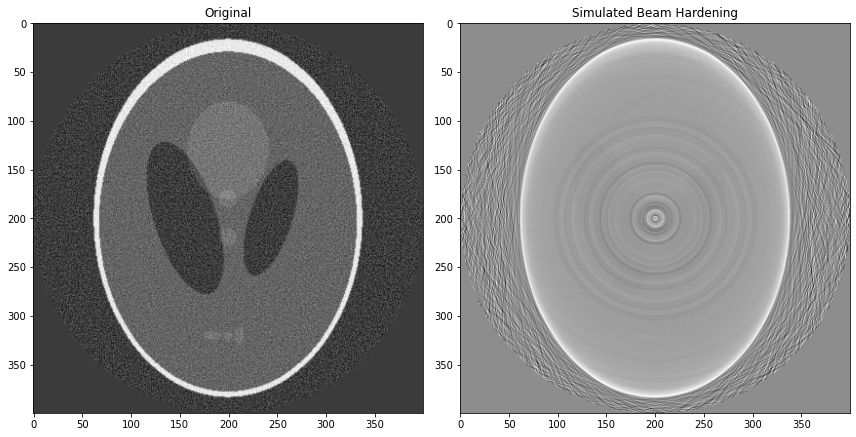

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon
from vandermonde_matrices_in_beam_hardening_corrections import *

p = shepp_logan_phantom()
p = rescale(p, scale=1, mode='reflect', multichannel=False)

theta = np.linspace(0., 360., 360, endpoint=False)
r = radon(p, theta=theta, circle=True)
noise_strength = 2
r += noise_strength * np.random.randn(r.shape[0], r.shape[1])
ideal = iradon(r, theta=theta, circle=True)
m, corrupted_r= corruptProjection(r, bh_strength = 0.1)

uncorrected = iradon(corrupted_r, theta=theta, circle=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
ax1.set_title("Original")
ax1.imshow(ideal, cmap=plt.cm.Greys_r)

ax2.set_title("Simulated Beam Hardening")
ax2.imshow(uncorrected, cmap=plt.cm.Greys_r)
          
fig.tight_layout()
plt.show()

0.008008176037568725


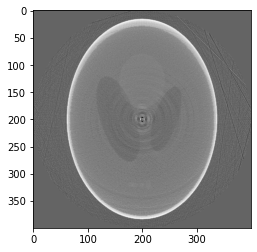

In [3]:
c = find2Dpolynomialcoefficients(corrupted_r, m, ideal, theta, 5)
corrected = correctAndDisplay(corrupted_r, m, c, theta)
print(mse(corrected, p))

In [0]:
coeff_dict = dict();
coeff_dict["Direct Inversion"] = square(c)

Generally speaking by adding noise the solution becomes harder to find in the direct inversion case, thats why we look towards iterative methods.

## Iterative methods: Gradient descent ##

Using Pytorch, let's start by setting up a naive gradient descent

In [0]:
import torch
import torch.nn as nn
import torch.cuda as tc
from torch.autograd import Variable

In [6]:
deg = 5
f = vanderComborecon(corrupted_r,m,theta, deg)
print(f.shape)

(160000, 25)


In [0]:
def update():
    y_hat = A@x
    loss = mse(y, y_hat)
    if t % 20000 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        x.sub_(lr * x.grad)
        x.grad.zero_()

In [8]:
x = torch.randn(f.shape[1]).double().cuda()
A=torch.tensor(f).double().cuda()
y_hat = A@x
y=torch.tensor(ideal.ravel()).cuda()
print(mse(y_hat,y))
x = nn.Parameter(x)

tensor(925376.6465, device='cuda:0', dtype=torch.float64)


In [9]:
lr = 1e-6
for t in range(200000): update()

tensor(925376.6465, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
tensor(1.5719, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3442, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2675, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2281, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1976, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1736, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1546, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1395, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1276, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


Similar to our direct SVD solution before, due to the poor conditioning of the problem our coefficients are unique and seem vary noisey.

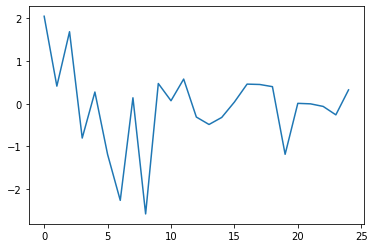

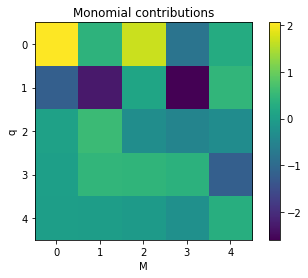

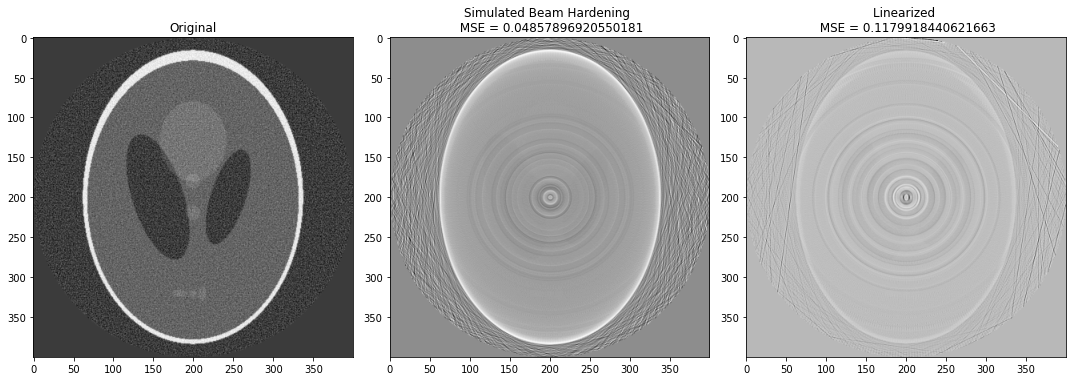

In [10]:
def compare_results():
  coef=x.cpu().detach().numpy()
  plt.plot(coef)
  plt.show()

  coeffs = visualizeCoefficients(coef)

  p = performCorrection2D(corrupted_r,m,coef)
  corrected = iradon(p, theta=theta, circle=True)
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 12))

  ax1.set_title("Original")
  ax1.imshow(ideal, cmap=plt.cm.Greys_r)

  ax2.set_title("Simulated Beam Hardening \n MSE = " + str(mse(uncorrected,ideal)))
  ax2.imshow(uncorrected, cmap=plt.cm.Greys_r)

  ax3.set_title("Linearized \n MSE = " + str(mse(corrected,ideal)))
  ax3.imshow(corrected, cmap=plt.cm.Greys_r)
            
  fig.tight_layout()
  plt.show()
  return coeffs

coeff_dict["Gradient Descent"]= compare_results()

First order gradient descent takes a LONG time to converge to a reasonable answer comparable to linear algebra direct methods, but let's next look at a second order method, Newton's method

## ADAM optimizer

This will enable faster convergence

Let's start with no regularization

In [11]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(f.shape[1], 1)  # 6*6 from image dimension
    def forward(self, x):
        x = self.fc1(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=25, out_features=1, bias=True)
)


In [12]:
x = torch.randn(f.shape[1]).double().cuda()
A=torch.tensor(f).double().cuda()
y_hat = A@x
y=torch.tensor(ideal.ravel()).cuda()
print(mse(y_hat,y))
x = nn.Parameter(x)
print(x.norm())

import torch.optim as optim

# create your optimizer
optimizer = optim.Adam([x], lr=0.005)
criterion = nn.MSELoss()
reg_strength = 0
def update2():
    optimizer.zero_grad() #zero gradient buffers
    y_hat = A@x
    loss = criterion(y_hat, y) + reg_strength*x.norm() #regularization for small coefficients
    loss.backward()
    optimizer.step()    # Does the update
    if t % 10000 == 0: print(loss)

tensor(53179.1077, device='cuda:0', dtype=torch.float64)
tensor(5.6957, device='cuda:0', dtype=torch.float64, grad_fn=<NormBackward0>)


tensor(53179.1077, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor(0.0986, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0091, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0082, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


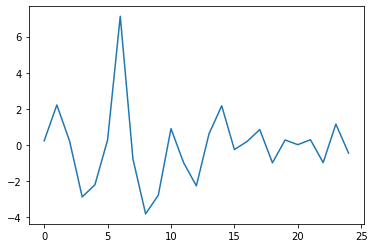

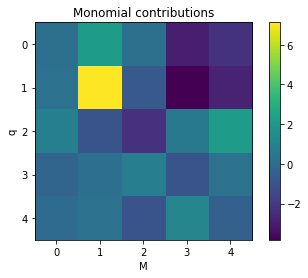

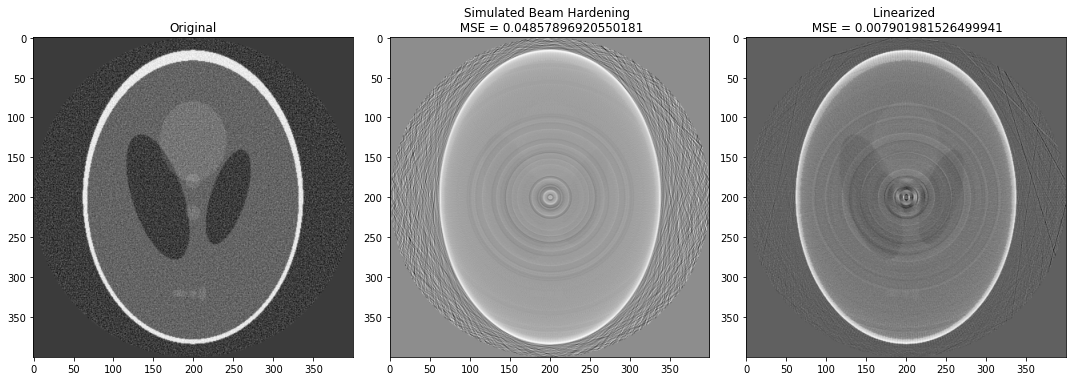

In [13]:
for t in range(40000): update2()
coeff_dict["ADAM Gradient Descent"]= compare_results()

In [14]:
x.norm()

tensor(10.4279, device='cuda:0', dtype=torch.float64, grad_fn=<NormBackward0>)

## L2 Regularization

In [30]:
x = torch.randn(f.shape[1]).double().cuda()
A=torch.tensor(f).double().cuda()
y_hat = A@x
y=torch.tensor(ideal.ravel()).cuda()
print(mse(y_hat,y))
x = nn.Parameter(x)
print(x.norm())

import torch.optim as optim

# create your optimizer
optimizer = optim.Adam([x], lr=0.1)
criterion = nn.MSELoss()
reg_strength = 0.1
def updateL2():
    optimizer.zero_grad() #zero gradient buffers
    y_hat = A@x
    loss = criterion(y_hat, y) + reg_strength*x.norm() #regularization for small coefficients
    loss.backward()
    optimizer.step()    # Does the update
    if t % 10000 == 0: print(loss)

tensor(25220.8031, device='cuda:0', dtype=torch.float64)
tensor(4.2264, device='cuda:0', dtype=torch.float64, grad_fn=<NormBackward0>)


tensor(25221.2257, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor(0.2456, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1736, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1588, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


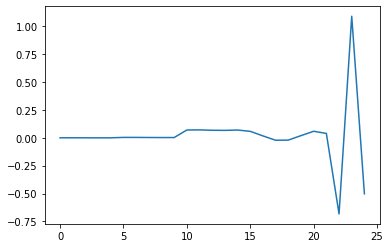

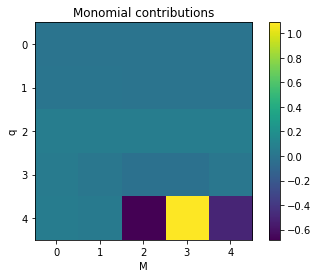

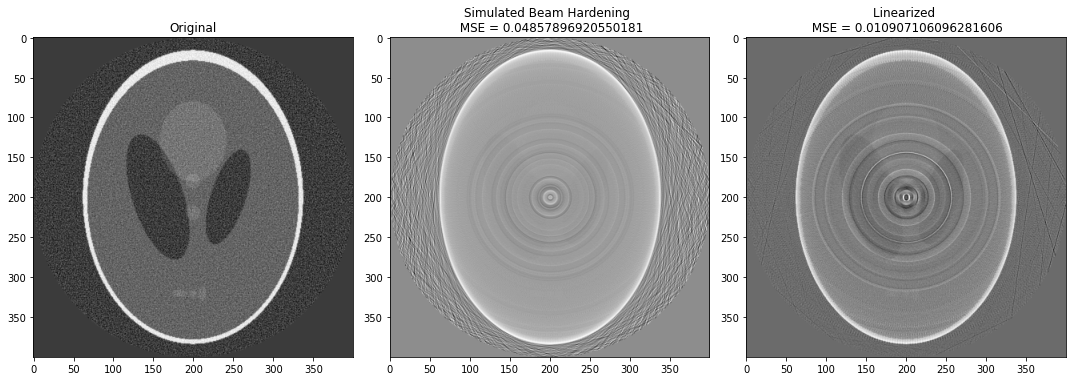

In [31]:
for t in range(40000): updateL2()
coeff_dict["ADAM L2 Gradient Descent"]= compare_results()

## L1 Regularization

In [32]:
x = torch.randn(f.shape[1]).double().cuda()
A=torch.tensor(f).double().cuda()
y_hat = A@x
y=torch.tensor(ideal.ravel()).cuda()
print(mse(y_hat,y))
x = nn.Parameter(x)
print(x.norm())

import torch.optim as optim

# create your optimizer
optimizer = optim.Adam([x], lr=0.01)
criterion = nn.MSELoss()
reg_strength = 0.1
def updateL1():
    optimizer.zero_grad() #zero gradient buffers
    y_hat = A@x
    loss = criterion(y_hat, y) + reg_strength*sum(abs(x)) #regularization for small coefficients
    loss.backward()
    optimizer.step()    # Does the update
    if t % 10000 == 0: print(loss)

tensor(15613.7639, device='cuda:0', dtype=torch.float64)
tensor(4.9389, device='cuda:0', dtype=torch.float64, grad_fn=<NormBackward0>)


tensor(15615.8393, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor(0.5459, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3264, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3478, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


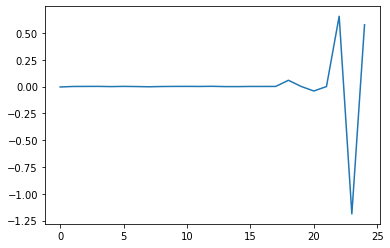

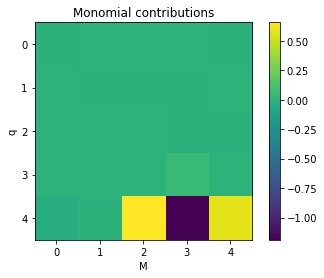

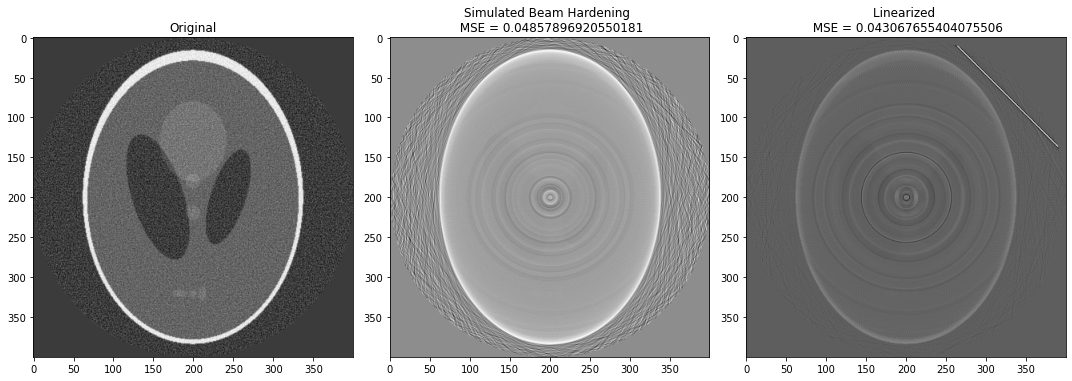

In [33]:
for t in range(40000): updateL1()
coeff_dict["ADAM L1 Gradient Descent"]= compare_results()

Compare the visualized coefficients between different types of regularizations L1, L2, nuclear, L_inf, what do you notice?

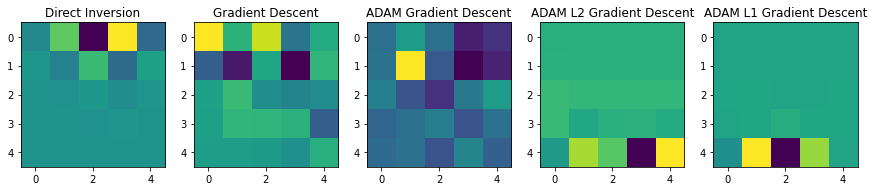

In [19]:
plt.figure(figsize=[15,8])
for i, d in enumerate(coeff_dict):
  plt.subplot(1,len(coeff_dict), i+1)
  plt.imshow(coeff_dict[d])
  plt.title(d)